#Model 1 - Logistic Regression

#General Imports

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, RandomRotation, RandomFlip, BatchNormalization, ReLU
from keras.callbacks import ReduceLROnPlateau
!pip install tensorflow
from tensorflow.keras import regularizers
from collections import Counter
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from numpy import std
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from skimage.color import rgb2gray
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
from google.colab import drive
import zipfile
from skimage import io
from sklearn.linear_model import LogisticRegression
from skimage import data
from skimage.color import rgb2gray
from numpy import asarray
import os 
import random
import matplotlib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
!pip install keras-cv --upgrade
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
# Import packages:
# numpy: the fundamental package for scientific computing with Python
# os: miscellaneous operating system interfaces
# matplotlib: a package for plotting figures
# tensorflow and keras: machine learning toolboxes 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Configure GPU Settings

In [2]:
#check how many GPUs you have on the device
gpus = tf.config.list_physical_devices('GPU')
print("List of physical GPUs:", gpus)
print("Num GPUs Available: ", len(gpus))
if gpus:
# Use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

List of physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


#Fetch dataset from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# with zipfile.ZipFile("COM2028_2023.zip", mode='r') as archive:
#   archive.printdir()
!ls "/content/drive/MyDrive"
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/COM2028_2023.zip', 'r')
zip_ref.extractall()
zip_ref.close()

'68321556 3.pdf'			     Football.mp4
'AC 11.09.18.docx'			    'FULHAM ROTA.xlsx'
'Anna Carter A level.gdoc'		    'headshot (1).png'
'Anna Carter A level.pdf'		     headshot.png
'Anna Carter Medical History.docx'	    'Memories Of The Future.gslides'
'Colab Notebooks'			     Nanny.gdoc
 COM2028_2023.zip			    'Robots taking over the world.mp4'
'Contract Update Letter - Anna Carter.pdf'  'Untitled presentation.gslides'


# Test loading first bloodcell

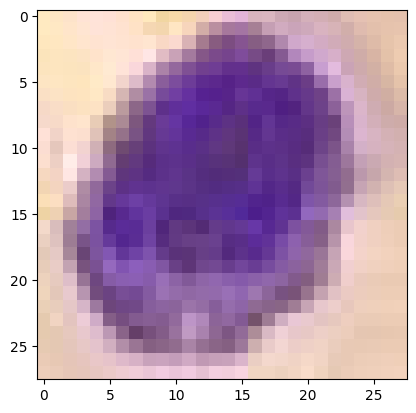

In [5]:
testbloodcell=plt.imread("train/000000.jpg")
plt.imshow(testbloodcell)

#Augmented Image Example

<bound method Iterator.next of <keras.preprocessing.image.NumpyArrayIterator object at 0x7f9fccbdfe50>>
1


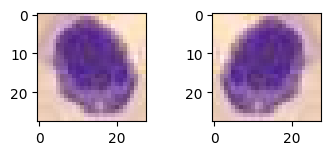

In [6]:
# example of brighting image augmentation
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from PIL import Image

# convert to numpy array
data = np.array(testbloodcell)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=2)
print(it.next)
# generate samples and plot
for i in range(2):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # generate batch of images
 batch = it.next()
 # convert to unsigned integers for viewing
 image = batch[0].astype('uint8')
 # plot raw pixel data
 pyplot.imshow(image)

print(len(batch))
# show the figure
pyplot.show()


# Load the Dataset into Variable



In [7]:
imagecounter = 0 # Initialise the counter
lr_data = [] # Initialise the data array

for bloodcellID in range(10000):
  # Convert the bloodcellID into a valid padded number
  currentbloodcell = str(bloodcellID)
  currentbloodcell = currentbloodcell.zfill(6)

  # Fetch the filename and add to the array
  lr_fetched = plt.imread(f'train/{currentbloodcell}.jpg')
  lr_data.append(lr_fetched)

print(len(lr_data))


10000


# Load Labels into Variable

In [8]:
lr_targets = []

f = open("train.txt", "r")

# Read the current line
for x in f:
  lr_truncated = x[17:] 
  lr_targets.append(lr_truncated)
f.close()

print(len(lr_targets))

10000


#Visualising class imbalance

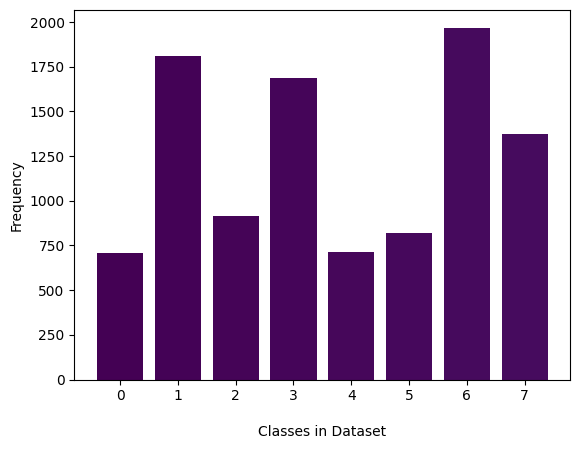

In [9]:
from collections import Counter

classes=Counter(lr_targets)
class_dict=dict(classes)

# Sort the x and y lists based on the x values in ascending order
x, y = zip(*sorted(class_dict.items()))

my_cmap = plt.get_cmap("viridis")
colors = my_cmap.colors

# Plot graph
plt.bar(x, y, color=colors)
plt.xlabel('Classes in Dataset')
plt.ylabel('Frequency')
plt.show()

# Split the Dataset into Training and Validation Sets

In [10]:
from collections import Counter
x_train_lr, x_validate_lr, y_train_lr, y_validate_lr = train_test_split(lr_data, lr_targets, test_size = 0.2, random_state= 42)

print(Counter(y_train_lr))

Counter({'6\n': 1595, '1\n': 1434, '3\n': 1348, '7\n': 1078, '2\n': 743, '5\n': 637, '4\n': 592, '0\n': 573})


# Reshape x_train_lr and x_validate_lr

In [11]:
x_train_lr = np.array(x_train_lr).reshape(8000, 28*28*3)
x_validate_lr = np.array(x_validate_lr).reshape(2000, 28*28*3)

print(np.array(x_train_lr).shape)
print(np.array(x_validate_lr).shape)

(8000, 2352)
(2000, 2352)


# Scaling Training and Validation Sets

In [12]:
x_train_lr=x_train_lr/255
x_validate_lr=x_validate_lr/255

# Standardise Data - Pre-processing

In [13]:
scaler = StandardScaler().fit(x_train_lr)

print(scaler.mean_)
print(scaler.scale_)

x_train_lr = scaler.transform(x_train_lr)
x_validate_lr = scaler.transform(x_validate_lr)


[0.90306765 0.78216225 0.72849608 ... 0.89369118 0.77009265 0.72584412]
[0.09893954 0.1163028  0.09145372 ... 0.10016332 0.11565084 0.08524401]


# Fit the model

In [14]:
# Default solver lbfgs, default C = 1
lr = LogisticRegression(multi_class="multinomial", max_iter=5000)

lr.fit(x_train_lr, y_train_lr)

LogisticRegression(max_iter=5000, multi_class='multinomial')

#Calculate Cross Validation

In [15]:
# Calculate 5-fold cross-validation
lr_cv_scores = cross_val_score(lr, x_validate_lr, y_validate_lr, cv=5)

print(lr_cv_scores)
print('Mean Accuracy: %.3f (%.3f)' % (mean(lr_cv_scores), std(lr_cv_scores)))

[0.6925 0.7075 0.7275 0.6875 0.73  ]
Mean Accuracy: 0.709 (0.017)


# Predictions on Training and Validation Set

In [16]:
lr_predictions_training = lr.predict(x_train_lr)

lr_predictions = lr.predict(x_validate_lr)

y_validate_pred_prob_lr = lr.predict_proba(x_validate_lr)

y_train_pred_prob_lr = lr.predict_proba(x_train_lr)

# Gather Accuracy Scores

Validation Accuray: 
77.2%

Training Accuray: 
99.7125%



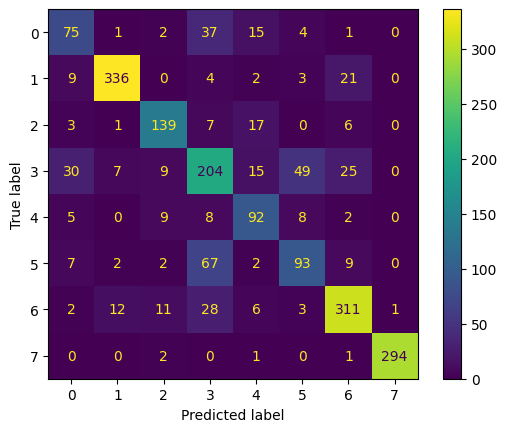

In [17]:
lr_accuracy = accuracy_score(lr_predictions, y_validate_lr)
lr_accuracy_training=accuracy_score(lr_predictions_training, y_train_lr)

print("Validation Accuray: ")
print(str(lr_accuracy*100) + "%\n")
print("Training Accuray: ")
print(str(lr_accuracy_training*100) + "%\n")

lr_conf_mx = confusion_matrix(y_validate_lr, lr_predictions)

lr_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lr_conf_mx)

lr_cm_display.plot()
plt.show()

#Precision Score

In [18]:
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
precision_score(y_validate_lr, lr_predictions, average='weighted')


0.7747240992243791

In [19]:
# The recall is intuitively the ability of the classifier to find all the positive samples.
recall_score(y_validate_lr, lr_predictions, average='weighted')


0.772

In [20]:
# Mean of the precision and recall
f1_score(y_validate_lr, lr_predictions, average="weighted")

0.7726294360386444

# Reshape Label Data for Loss Function (2D)

In [21]:
y_validate_1_2d_lr = np.reshape(y_validate_lr, (-1, 1))
y_validate_1_2d_lr = y_validate_1_2d_lr.astype(int)


y_train_1_2d_lr = np.reshape(y_train_lr, (-1, 1))
y_train_1_2d_lr = y_train_1_2d_lr.astype(int)

# Calculate Log loss

In [22]:
from sklearn.metrics import log_loss

lr_validation_loss = log_loss(y_validate_1_2d_lr, y_validate_pred_prob_lr)
lr_training_loss = log_loss(y_train_1_2d_lr, y_train_pred_prob_lr)

print("Validation Loss: ", lr_validation_loss)
print("Training Loss: ", lr_training_loss)

Validation Loss:  1.1528208232693935
Training Loss:  0.044431539609449275


# Classification Report

In [23]:
from sklearn.metrics import classification_report
# target_names = ['0', '1','2','3','4','5','6','7']
print(classification_report(y_validate_lr, lr_predictions))

              precision    recall  f1-score   support

          0
       0.57      0.56      0.56       135
          1
       0.94      0.90      0.92       375
          2
       0.80      0.80      0.80       173
          3
       0.57      0.60      0.59       339
          4
       0.61      0.74      0.67       124
          5
       0.58      0.51      0.54       182
          6
       0.83      0.83      0.83       374
          7
       1.00      0.99      0.99       298

    accuracy                           0.77      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.77      0.77      0.77      2000



# Plot ROC Curve

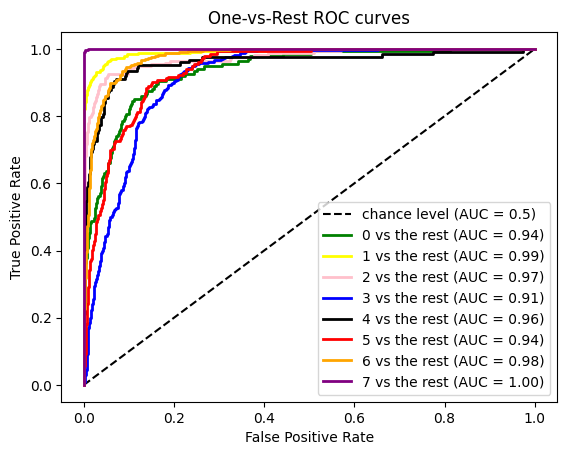

ROC for specific class using micro-averaged OvR


In [24]:
label_binarizer_lr = LabelBinarizer().fit(y_train_lr)
y_onehot_test = label_binarizer_lr.transform(y_validate_lr)

class_of_interest = ["0", "1", "2", "3", "4", "5", "6", "7"]
colors = ["green", "yellow", "pink", "blue", "black", "red", "orange", "purple"]

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

# ROC for each class
for i, class_id in enumerate(class_of_interest):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_validate_pred_prob_lr[:, i])
    roc_auc = roc_auc_score(y_onehot_test[:, i], y_validate_pred_prob_lr[:, i])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_id} vs the rest (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

# ROC for specific class using micro-averaged OvR
print('ROC for specific class using micro-averaged OvR')



# Model 2 - Logistic Regression + Hyperparametere Tuning

#Fetching the dataset from Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# with zipfile.ZipFile("COM2028_2023.zip", mode='r') as archive:
#   archive.printdir()
!ls "/content/drive/MyDrive"
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/COM2028_2023.zip', 'r')
zip_ref.extractall()
zip_ref.close()

'68321556 3.pdf'			     Football.mp4
'AC 11.09.18.docx'			    'FULHAM ROTA.xlsx'
'Anna Carter A level.gdoc'		    'headshot (1).png'
'Anna Carter A level.pdf'		     headshot.png
'Anna Carter Medical History.docx'	    'Memories Of The Future.gslides'
'Colab Notebooks'			     Nanny.gdoc
 COM2028_2023.zip			    'Robots taking over the world.mp4'
'Contract Update Letter - Anna Carter.pdf'  'Untitled presentation.gslides'


# Testing Loading One Bloodcell

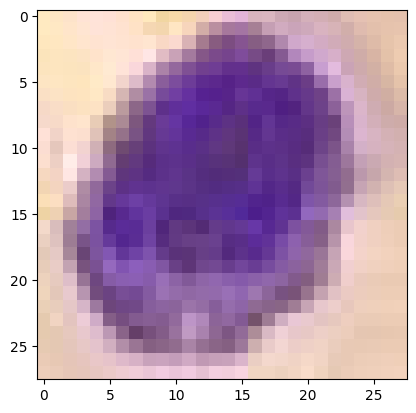

In [27]:
lr2_testbloodcell=plt.imread("train/000000.jpg")
plt.imshow(lr2_testbloodcell);

# Load the dataset into a variable to work with




In [28]:
lr2_data = [] # Initialise the data array


for bloodcellID in range(10000):
  # Convert the bloodcellID into a valid padded number
  currentbloodcell = str(bloodcellID)
  currentbloodcell = currentbloodcell.zfill(6)

  # Fetch the filename and add to the array
  lr2_fetched = plt.imread(f'train/{currentbloodcell}.jpg')
  lr2_data.append(lr2_fetched)

print(len(lr2_data))

10000


# Load the target labels into a variable

In [29]:
lr2_targets = []

f = open("train.txt", "r")

# Read the current line
for x in f:
  lr2_truncated = x[17:] 
  lr2_targets.append(lr2_truncated)

f.close()
print(len(lr2_targets))

10000


# Split the Data into Training and Validation Sets

In [30]:
x_train_lr2, x_validate_lr2, y_train_lr2, y_validate_lr2 = train_test_split(lr2_data, lr2_targets, test_size = 0.2, random_state= 42)

print(Counter(y_train_lr2))

Counter({'6\n': 1595, '1\n': 1434, '3\n': 1348, '7\n': 1078, '2\n': 743, '5\n': 637, '4\n': 592, '0\n': 573})


# Reshape x_train_lr2 and x_validate_lr2

In [31]:
x_train_lr2 = np.array(x_train_lr2).reshape(8000, 28*28*3)
x_validate_lr2 = np.array(x_validate_lr2).reshape(2000, 28*28*3)

print(np.array(x_train_lr2).shape)
print(np.array(x_validate_lr2).shape)

(8000, 2352)
(2000, 2352)


# Scale x_train_lr2 and x_validate_lr2

In [32]:
x_train_lr2=x_train_lr2/255
x_validate_lr2=x_validate_lr2/255

# Standardise Data - Pre-processing

In [33]:
from sklearn.preprocessing import StandardScaler

lr2_scaler = StandardScaler()

x_train_lr2 = lr2_scaler.fit_transform(x_train_lr2)

x_validate_lr2 = lr2_scaler.fit_transform(x_validate_lr2)


# Fit the model

In [34]:
# Add more regularization
lr2 = LogisticRegression(C = 0.01, random_state = 42, max_iter=5000, multi_class='multinomial', class_weight='balanced')

lr2.fit(x_train_lr2, y_train_lr2)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=5000,
                   multi_class='multinomial', random_state=42)

#Calculate Cross Validation

In [35]:
# 5-fold cross-validation
lr2_cv_scores = cross_val_score(lr2, x_validate_lr2, y_validate_lr2, cv=5)

print(lr2_cv_scores)
print('Mean Accuracy: %.3f (%.3f)' % (mean(lr2_cv_scores), std(lr2_cv_scores)))

[0.6875 0.7075 0.78   0.745  0.7275]
Mean Accuracy: 0.730 (0.032)


# Predict values

In [36]:
lr2_predictions = lr2.predict(x_validate_lr2)
lr2_predictions_training = lr2.predict(x_train_lr2)
y_validate_pred_prob_lr2 = lr2.predict_proba(x_validate_lr2)

y_train_pred_prob_lr2 = lr2.predict_proba(x_train_lr2)

# Gather Accuracy Scores

Accuracy: 
80.35%

Training Accuray: 
90.4625%



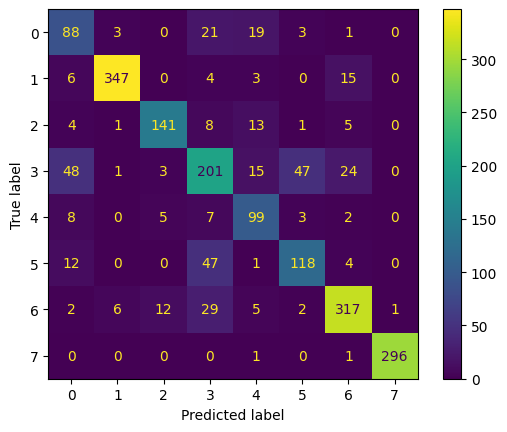

In [37]:
lr2_accuracy = accuracy_score(lr2_predictions, y_validate_lr2)
lr2_accuracy_training=accuracy_score(lr2_predictions_training, y_train_lr2)

print("Accuracy: ")
print(str(lr2_accuracy*100) + "%\n")
print("Training Accuray: ")
print(str(lr2_accuracy_training*100) + "%\n")

lr2_conf_mx = confusion_matrix(y_validate_lr2, lr2_predictions)
lr2_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = lr2_conf_mx)

# Plot confusion matrix
lr2_cm_display.plot()
plt.show()

#Precision Scores

In [38]:
precision_score(y_validate_lr2, lr2_predictions, average='weighted')

0.8105302019644146

In [39]:
recall_score(y_validate_lr2, lr2_predictions, average='weighted')

0.8035

In [40]:
f1_score(y_validate_lr2, lr2_predictions, average='weighted')

0.8056192173802719

# Reshape Labels for Loss Function (2D)

In [41]:
y_validate_lr2_2d = np.reshape(y_validate_lr2, (-1, 1))
y_validate_lr2_2d = y_validate_lr2_2d.astype(int)

y_train_lr2_2d = np.reshape(y_train_lr2, (-1, 1))
y_train_lr2_2d = y_train_lr2_2d.astype(int)


# Log loss and ROC curve

In [42]:
lr2_validation_loss = log_loss(y_validate_lr2_2d, y_validate_pred_prob_lr2)
lr2_training_loss = log_loss(y_train_lr2_2d, y_train_pred_prob_lr2)

print("Validation Loss: ", lr2_validation_loss)
print("Training Loss: ", lr2_training_loss)

Validation Loss:  0.5690182667444879
Training Loss:  0.3178076722213595


# Classification Report

In [43]:
target_names = ['0', '1','2','3','4','5','6','7']
print(classification_report(y_validate_lr2, lr2_predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.52      0.65      0.58       135
           1       0.97      0.93      0.95       375
           2       0.88      0.82      0.84       173
           3       0.63      0.59      0.61       339
           4       0.63      0.80      0.71       124
           5       0.68      0.65      0.66       182
           6       0.86      0.85      0.85       374
           7       1.00      0.99      0.99       298

    accuracy                           0.80      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.81      0.80      0.81      2000



# Plot ROC Curve

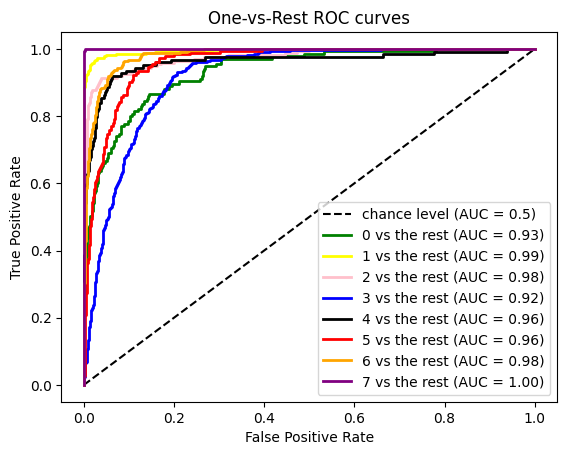

ROC for specific class using micro-averaged OvR


In [44]:
lr2_label_binarizer = LabelBinarizer().fit(y_train_lr2)
y_onehot_test_lr2 = lr2_label_binarizer.transform(y_validate_lr2)

class_of_interest = ["0", "1", "2", "3", "4", "5", "6", "7"]
colors = ["green", "yellow", "pink", "blue", "black", "red", "orange", "purple"]

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

# ROC for each class
for i, class_id in enumerate(class_of_interest):
    fpr, tpr, _ = roc_curve(y_onehot_test_lr2[:, i], y_validate_pred_prob_lr2[:, i])
    roc_auc = roc_auc_score(y_onehot_test_lr2[:, i], y_validate_pred_prob_lr2[:, i])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_id} vs the rest (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

# ROC for specific class using micro-averaged OvR
print('ROC for specific class using micro-averaged OvR')



#Plot Cross Validation Scores of Model 1 and 2

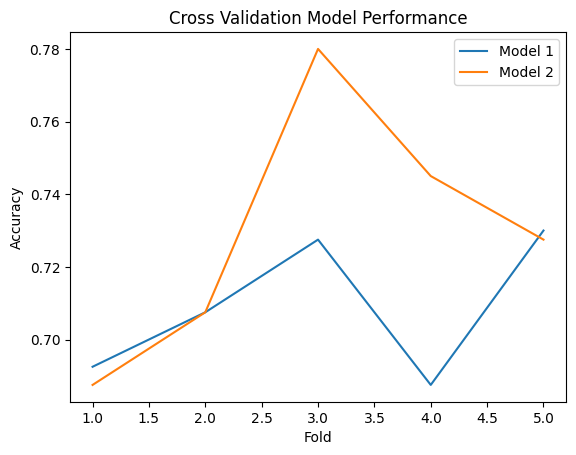

In [45]:
# Create a list of fold numbers for the x-axis
folds = [1, 2, 3, 4, 5]

# Plot the training and cross-validation scores on the same graph
plt.plot(folds, lr_cv_scores, label='Model 1')
plt.plot(folds, lr2_cv_scores, label='Model 2')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross Validation Model Performance')
plt.legend()
plt.show()

# Model 3 - MLP

# Fetch dataset from Google Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive"
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/COM2028_2023.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'68321556 3.pdf'			     Football.mp4
'AC 11.09.18.docx'			    'FULHAM ROTA.xlsx'
'Anna Carter A level.gdoc'		    'headshot (1).png'
'Anna Carter A level.pdf'		     headshot.png
'Anna Carter Medical History.docx'	    'Memories Of The Future.gslides'
'Colab Notebooks'			     Nanny.gdoc
 COM2028_2023.zip			    'Robots taking over the world.mp4'
'Contract Update Letter - Anna Carter.pdf'  'Untitled presentation.gslides'


#Extract data

In [47]:
# holds training data 
data_nn=[]

for index_nn in range(10000):
  index_str_nn=str(index_nn)
  reformat_nn=index_str_nn.zfill(6)
  # load the image
  image_nn=plt.imread(f'/content/train/{reformat_nn}.jpg')
  pixels_nn = asarray(image_nn)
  data_nn.append(pixels_nn)
data_nn=asarray(data_nn)

In [48]:
# Hold target labels
target_nn=[]

file_train_nn = open('train.txt', 'r')
lines_nn = file_train_nn.readlines()

for line_nn in lines_nn:
  array_nn=line_nn.split(" ")
  number_nn=int(array_nn[1].strip())
  target_nn.append(number_nn)
# Convert int array to np array
target_nn=asarray(target_nn)
# Convert int's to int32 type
target_nn=target_nn.astype(np.int32)

print(target_nn)

[3 3 7 ... 2 6 1]


# Define input shape

In [49]:
# Model / data parameters
num_classes = 8
input_shape = (28, 28, 3)

# Split Data into Training and Validation Sets

In [50]:
# Split training and target data to create a validation set
x_train_nn, x_validate_nn, y_train_nn, y_validate_nn = train_test_split(data_nn, target_nn, test_size=0.2, random_state=42)

#One-Hot-Encoding y_train_nn and y_validate_nn

In [51]:
y_validate_original_nn=y_validate_nn
y_train_nn = to_categorical(y_train_nn)
y_validate_nn = to_categorical(y_validate_nn)

# Scale x_train_nn and x_validate_nn

In [52]:
x_train_nn=x_train_nn/255
x_validate_nn=x_validate_nn/255

#Reshape and Standardise

In [53]:
x_train_nn=x_train_nn.reshape(-1,28*28*3)
x_validate_nn=x_validate_nn.reshape(-1,28*28*3)

scaler_nn = StandardScaler().fit(x_train_nn)
print(scaler_nn.mean_)
print(scaler_nn.scale_)
x_train_nn = scaler_nn.transform(x_train_nn)

x_validate_nn = scaler_nn.transform(x_validate_nn)

[0.90306765 0.78216225 0.72849608 ... 0.89369118 0.77009265 0.72584412]
[0.09893954 0.1163028  0.09145372 ... 0.10016332 0.11565084 0.08524401]


# Create MLP Model

In [54]:
# Set up the model size, as each image has 28*28*3 pixels. The input should be 28*28*3.
# The output should have 8 neurons as we have 8 classes.
# We use ReLU for hidden layers and Softmax for the last output layer.
# The sizes of the three hidden layers are set to 64, 128 and 256.

n_inputs = 28*28*3
n_hidden1 = 64
n_hidden2 = 128
n_hidden3 = 256
n_outputs = 8
dropout=0.3

model_nn = keras.Sequential(
  [
      keras.Input(shape=n_inputs),
      layers.Dense(n_hidden1, name='hidden1', activation='relu'),
      BatchNormalization(),
      ReLU(),
      layers.Dense(n_hidden2, name='hidden2', activation='relu'),
      BatchNormalization(),
      ReLU(),
      layers.Dense(n_hidden3, name='hidden3', activation='relu'),
      BatchNormalization(),
      ReLU(),
      layers.Dense(8, activation="softmax")
  ]
)

In [55]:
# Define the loss function
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy 

# crossentropy = keras.losses.CategoricalCrossentropy()

# # Set some hyperparameters and the evaluation metric
# learning_rate = 0.001
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# accuracy = keras.metrics.CategoricalAccuracy()


# model.compile(loss=crossentropy, optimizer=optimizer, metrics=[accuracy])
# model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data = (x_validate,y_validate), shuffle=True)


# Fit Model

In [56]:
# Compile the model
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
history_nn=model_nn.fit(x_train_nn, y_train_nn, validation_split=0.2, epochs=60, batch_size=64, )

Epoch 1/60
100/100 [==============================] - 5s 12ms/step - loss: 1.1223 - accuracy: 0.6014 - val_loss: 1.0890 - val_accuracy: 0.6206
Epoch 2/60
100/100 [==============================] - 1s 9ms/step - loss: 0.6048 - accuracy: 0.7937 - val_loss: 0.8658 - val_accuracy: 0.7144
Epoch 3/60
100/100 [==============================] - 1s 8ms/step - loss: 0.4571 - accuracy: 0.8423 - val_loss: 0.6967 - val_accuracy: 0.7656
Epoch 4/60
100/100 [==============================] - 1s 8ms/step - loss: 0.3577 - accuracy: 0.8755 - val_loss: 0.6469 - val_accuracy: 0.7825
Epoch 5/60
100/100 [==============================] - 1s 7ms/step - loss: 0.3138 - accuracy: 0.8864 - val_loss: 0.6278 - val_accuracy: 0.7944
Epoch 6/60
100/100 [==============================] - 1s 6ms/step - loss: 0.2551 - accuracy: 0.9147 - val_loss: 0.6384 - val_accuracy: 0.8062
Epoch 7/60
100/100 [==============================] - 1s 6ms/step - loss: 0.2060 - accuracy: 0.9314 - val_loss: 0.6972 - val_accuracy: 0.8069
Epoch

# Calculate Metrics and Accuracy/Loss Graphs 

63/63 [==============================] - 0s 3ms/step


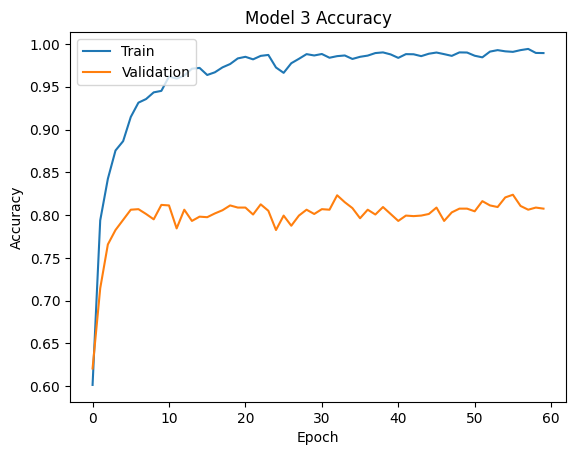

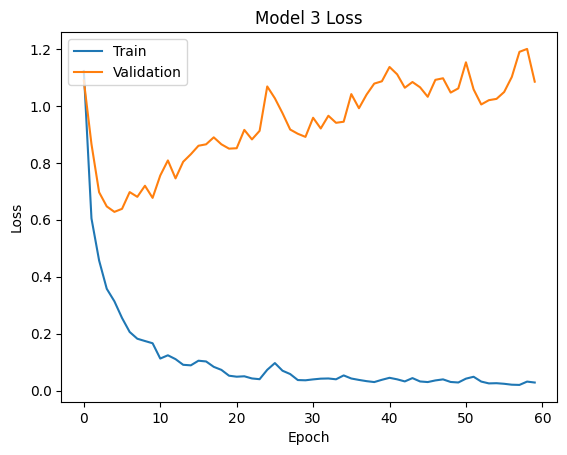

In [57]:
# Evaluate the model with the validation data
train_loss_nn, train_accuracy_nn = model_nn.evaluate(x_train_nn, y_train_nn, verbose=0)
val_loss_nn, val_accuracy_nn = model_nn.evaluate(x_validate_nn, y_validate_nn, verbose=0)

# Predict the class labels for the validation data
y_val_pred_nn = model_nn.predict(x_validate_nn)
y_val_true_nn = np.argmax(y_validate_nn, axis=1)
y_val_pred_nn = np.argmax(y_val_pred_nn, axis=1)

# Calculate the precision score for all classes
precision_nn = precision_score(y_val_true_nn, y_val_pred_nn, average='weighted')

# Calculate the f1 score for all classes
f1_nn = f1_score(y_val_true_nn, y_val_pred_nn, average='weighted')

# Calculate the recall score for all classes for this fold
recall_nn = recall_score(y_val_true_nn, y_val_pred_nn, average='weighted')

# Plot the training and validation accuracy over epochs
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Confusion Matrix

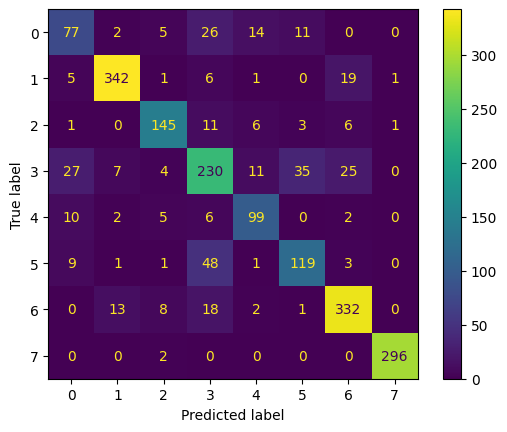

Validation Accuracy:  0.8199999928474426
Training Accuracy:  0.9607499837875366


In [58]:
# Calculate the confusion matrix and average accuracy
conf_mat_nn = confusion_matrix(y_val_true_nn, y_val_pred_nn)

# Plot confusion matrix  
cm_display_nn = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_nn)
cm_display_nn.plot()
plt.show()

print('Validation Accuracy: ', val_accuracy_nn)
print('Training Accuracy: ', train_accuracy_nn)

# Summarise Performance

In [59]:
# Summarize the performance
print('Precision: ', precision_nn)
print('Recall: ', recall_nn)
print('F1-score mean', f1_nn)
print('Train Loss: ', train_loss_nn )
print('Validation Loss: ', val_loss_nn)

Precision:  0.8196728371627562
Recall:  0.82
F1-score mean 0.819580762074665
Train Loss:  0.22075997292995453
Validation Loss:  1.0758156776428223


# Classification Report

In [60]:
target_names = ['0', '1','2','3','4','5','6','7']
print(classification_report(y_validate_original_nn, y_val_pred_nn, target_names=target_names))

              precision    recall  f1-score   support

           0       0.60      0.57      0.58       135
           1       0.93      0.91      0.92       375
           2       0.85      0.84      0.84       173
           3       0.67      0.68      0.67       339
           4       0.74      0.80      0.77       124
           5       0.70      0.65      0.68       182
           6       0.86      0.89      0.87       374
           7       0.99      0.99      0.99       298

    accuracy                           0.82      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.82      0.82      0.82      2000



# Model 4 - CNN

#Mount Google Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# with zipfile.ZipFile("COM2028_2023.zip", mode='r') as archive:
#   archive.printdir()
!ls "/content/drive/MyDrive"
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/COM2028_2023.zip', 'r')
zip_ref.extractall()
zip_ref.close()

'68321556 3.pdf'			     Football.mp4
'AC 11.09.18.docx'			    'FULHAM ROTA.xlsx'
'Anna Carter A level.gdoc'		    'headshot (1).png'
'Anna Carter A level.pdf'		     headshot.png
'Anna Carter Medical History.docx'	    'Memories Of The Future.gslides'
'Colab Notebooks'			     Nanny.gdoc
 COM2028_2023.zip			    'Robots taking over the world.mp4'
'Contract Update Letter - Anna Carter.pdf'  'Untitled presentation.gslides'


In [63]:
seed(101)
tf.random.set_seed(101)

#Extract data

In [64]:
# holds training data 
data_cnn=[]

for index in range(10000):
  index_str=str(index)
  reformat=index_str.zfill(6)
  # load the image
  image=plt.imread(f'/content/train/{reformat}.jpg')
  pixels = asarray(image)
  data_cnn.append(pixels)
data_cnn=asarray(data_cnn)

In [65]:
# Hold target labels
target_cnn=[]

file_train = open('train.txt', 'r')
lines = file_train.readlines()

for line in lines:
  array=line.split(" ")
  number=int(array[1].strip())
  target_cnn.append(number)
# Convert int array to np array
target_cnn=asarray(target_cnn)
# Convert int's to int32 type
target_cnn=target_cnn.astype(np.int32)

# Split Data into Training and Validation Sets

In [66]:
# Split training and target data to create a validation set
x_train_cnn, x_validate_cnn, y_train_cnn, y_validate_cnn = train_test_split(data_cnn, target_cnn, test_size=0.2, random_state=42)
y_train_original_cnn=y_train_cnn

# Check Data Shape

In [67]:
# Check training and validation date before you design the network and train it
print("Training data shape:", x_train_cnn.shape)
print(x_train_cnn.shape[0], "train samples")
print("Test data shape:", x_validate_cnn.shape)
print(x_validate_cnn.shape[0], "test samples")

print("Training label shape:", y_train_cnn.shape)
print(y_train_cnn.shape[0], "train labels")
print("Test label shape:", y_validate_cnn.shape)
print(y_validate_cnn.shape[0], "test labels")



Training data shape: (8000, 28, 28, 3)
8000 train samples
Test data shape: (2000, 28, 28, 3)
2000 test samples
Training label shape: (8000,)
8000 train labels
Test label shape: (2000,)
2000 test labels


#One-hot-Encoding

In [68]:
from keras.utils import to_categorical
to_categorical(target_cnn[0], 10)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [69]:
y_validate_original_cnn=y_validate_cnn
y_train_cnn = to_categorical(y_train_cnn)
y_validate_cnn = to_categorical(y_validate_cnn)

# Scale x_train_cnn and x_validate_cnn

In [70]:
x_train_cnn=x_train_cnn/255
x_validate_cnn=x_validate_cnn/255

#Build Model 4a

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, RandomRotation, RandomFlip
from keras.callbacks import ReduceLROnPlateau


model_cnn=Sequential([
    # Layers here.
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,3)),
    Conv2D(32, kernel_size=3, activation="relu"),
    Conv2D(64, kernel_size=3, activation="relu"),
    Conv2D(64, kernel_size=3, activation="relu"),
    Conv2D(64, kernel_size=3, activation="relu"),
    MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding="valid"),
    Flatten(),
    Dense(8, activation="softmax")
])

#Build Model 4b

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, RandomRotation, RandomFlip, BatchNormalization, ReLU
from keras.callbacks import ReduceLROnPlateau


model_cnn_b=Sequential([
    # Layers here.
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    Conv2D(32, kernel_size=3, activation=None, input_shape=(28,28,3)),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, kernel_size=3, activation=None),
    BatchNormalization(),
    ReLU(),
    Dropout(0.25),
    Conv2D(64, kernel_size=3, activation=None),
    BatchNormalization(),
    ReLU(),
    Conv2D(64, kernel_size=3, activation=None),
    BatchNormalization(),
    ReLU(),
    Dropout(0.25),
    Conv2D(64, kernel_size=3, activation=None),
    BatchNormalization(),
    ReLU(),
    Dropout(0.35),
    MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding="valid"),
    Flatten(),
    Dense(8, activation="softmax")
])

# Build Model 4c

In [73]:
model_cnn_c=Sequential([
    # Preprocessing layers
    RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    # Model layers
    Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,3)),
    Conv2D(32, kernel_size=3, activation=None, kernel_regularizer=regularizers.L2(0.01)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Conv2D(64, kernel_size=3, activation="relu"),
    Conv2D(64, kernel_size=3, activation=None, kernel_regularizer=regularizers.L2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size=3, activation="relu"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding="valid"),
    Flatten(),
    Dense(8, activation="softmax")
])

#Train Model 4a

In [74]:
opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_learning_rate=ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0000001)
model_cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
epochs=80
batch_size=64

# Train model
history_cnn=model_cnn.fit(x_train_cnn, y_train_cnn, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[reduce_learning_rate])


Epoch 1/80
100/100 [==============================] - 6s 15ms/step - loss: 1.0235 - accuracy: 0.6191 - val_loss: 0.5257 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 1s 12ms/step - loss: 0.5545 - accuracy: 0.8058 - val_loss: 0.4916 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 1s 11ms/step - loss: 0.4978 - accuracy: 0.8258 - val_loss: 0.4927 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 4/80
100/100 [==============================] - 1s 10ms/step - loss: 0.4216 - accuracy: 0.8550 - val_loss: 0.3969 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 5/80
100/100 [==============================] - 1s 10ms/step - loss: 0.3793 - accuracy: 0.8697 - val_loss: 0.3822 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 6/80
100/100 [==============================] - 1s 10ms/step - loss: 0.3797 - accuracy: 0.8612 - val_loss: 0.4087 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 7/80
100/100 [==============================] - 1s 11ms/st

#Train Model 4b (Checkpoint Callback)

In [75]:
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints',
    save_weights_only=True,  # Record only weights (see model.save_weights vs model.save)
    monitor='val_accuracy',  # Evaluate model using accuracy metric on the validation set
    mode='max',        # Determine best model based on 'max' of the 'val_accuracy' score
    save_best_only=True)   # Keep only the best-performing model (i.e. overwrite only when the model has improved)

opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_learning_rate=ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0000001)
model_cnn_b.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
epochs=80
batch_size=64
history_cnn_b=model_cnn_b.fit(x_train_cnn, y_train_cnn, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[reduce_learning_rate])


Epoch 1/80
100/100 [==============================] - 7s 20ms/step - loss: 3.7355 - accuracy: 0.6036 - val_loss: 10.1848 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 2s 16ms/step - loss: 0.6487 - accuracy: 0.7856 - val_loss: 7.6176 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 2s 17ms/step - loss: 0.5618 - accuracy: 0.8227 - val_loss: 5.8555 - val_accuracy: 0.1969 - lr: 0.0010
Epoch 4/80
100/100 [==============================] - 2s 17ms/step - loss: 0.5966 - accuracy: 0.8211 - val_loss: 5.6740 - val_accuracy: 0.1319 - lr: 0.0010
Epoch 5/80
100/100 [==============================] - 2s 19ms/step - loss: 0.4730 - accuracy: 0.8491 - val_loss: 1.3899 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 6/80
100/100 [==============================] - 2s 19ms/step - loss: 0.4574 - accuracy: 0.8505 - val_loss: 1.1072 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 7/80
100/100 [==============================] - 2s 17ms/s

#Train Model 4c (Checkpoint Callback)

In [76]:
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints',
    save_weights_only=True,  # Record only weights (see model.save_weights vs model.save)
    monitor='val_accuracy',  # Evaluate model using accuracy metric on the validation set
    mode='max',        # Determine best model based on 'max' of the 'val_accuracy' score
    save_best_only=True)   # Keep only the best-performing model (i.e. overwrite only when the model has improved)

# Train model
epochs=80
batch_size=64

opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_learning_rate=ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0000001)

model_cnn_c.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# history_cnn_c=model_cnn_c.fit(x_train_cnn, y_train_cnn, validation_data=(x_validate_cnn, y_validate_cnn), epochs=epochs, batch_size=batch_size, callbacks=[reduce_learning_rate, checkpoint_callback])
history_cnn_c=model_cnn_c.fit(x_train_cnn, y_train_cnn, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[reduce_learning_rate, checkpoint_callback])



Epoch 1/80
100/100 [==============================] - 5s 19ms/step - loss: 2.2009 - accuracy: 0.6072 - val_loss: 7.9005 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 2s 15ms/step - loss: 1.0346 - accuracy: 0.7661 - val_loss: 9.5341 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 2s 16ms/step - loss: 0.8150 - accuracy: 0.7908 - val_loss: 10.0276 - val_accuracy: 0.1275 - lr: 0.0010
Epoch 4/80
100/100 [==============================] - 2s 17ms/step - loss: 0.6946 - accuracy: 0.8103 - val_loss: 6.0286 - val_accuracy: 0.1425 - lr: 0.0010
Epoch 5/80
100/100 [==============================] - 2s 18ms/step - loss: 0.6319 - accuracy: 0.8155 - val_loss: 5.5593 - val_accuracy: 0.1462 - lr: 0.0010
Epoch 6/80
100/100 [==============================] - 2s 15ms/step - loss: 0.6012 - accuracy: 0.8231 - val_loss: 1.2578 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 7/80
100/100 [==============================] - 2s 16ms/s

#Model Summaries

In [77]:
# Model 4a
model_cnn.summary()

# Model 4b
model_cnn_b.summary()

# Model 4c
model_cnn_c.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (64, 28, 28, 3)           0         
                                                                 
 random_rotation (RandomRota  (64, 28, 28, 3)          0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (64, 26, 26, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (64, 24, 24, 32)          9248      
                                                                 
 conv2d_2 (Conv2D)           (64, 22, 22, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (64, 20, 20, 64)          36928     
                                                      

# Evaluation: Metrics, Loss and ROC Graph Model 4a

63/63 [==============================] - 0s 2ms/step


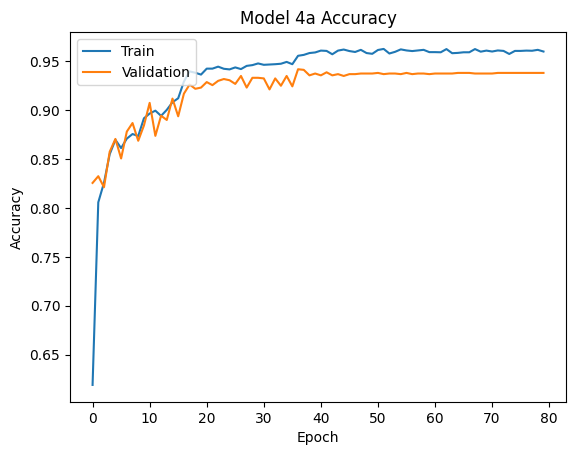

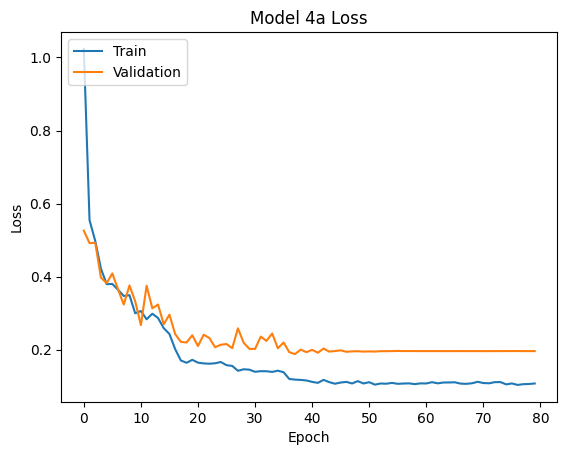

63/63 [==============================] - 0s 2ms/step


<ipython-input-78-f0e01cfdf9d7>:57: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


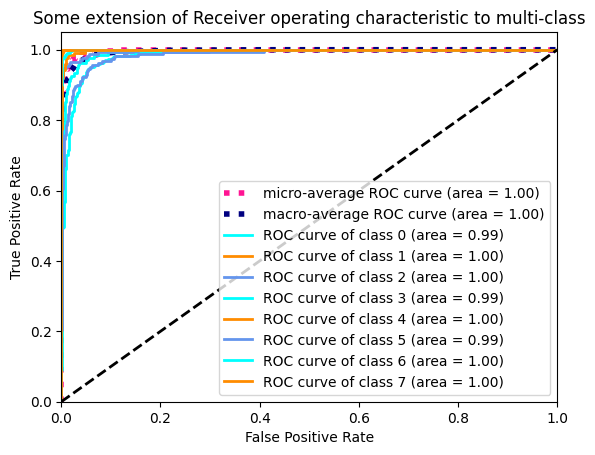

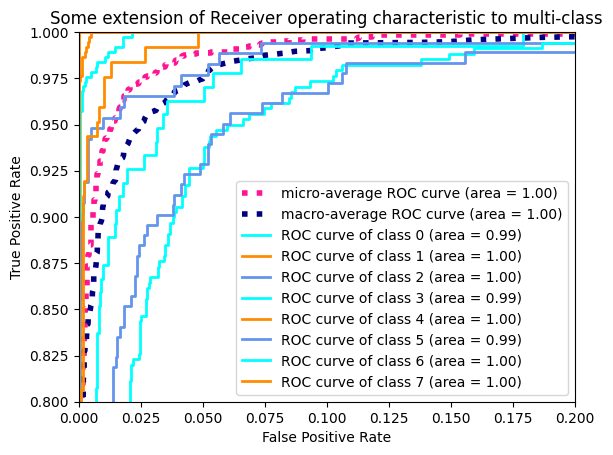

In [78]:
# Evaluate the model on the validation data
train_loss_cnn, train_accuracy_cnn = model_cnn.evaluate(x_train_cnn, y_train_cnn, verbose=0)
val_loss_cnn, val_accuracy_cnn = model_cnn.evaluate(x_validate_cnn, y_validate_cnn, verbose=0)

# Predict the class labels for the validation data
y_val_pred_cnn = model_cnn.predict(x_validate_cnn)
y_val_true_cnn = np.argmax(y_validate_cnn, axis=1)
y_val_pred_cnn = np.argmax(y_val_pred_cnn, axis=1)

# Precision scores
precision_cnn = precision_score(y_validate_original_cnn, y_val_pred_cnn, average='weighted')
f1_cnn = f1_score(y_validate_original_cnn, y_val_pred_cnn, average='weighted')
recall_cnn = recall_score(y_validate_original_cnn, y_val_pred_cnn, average='weighted')

# Plot the training and validation accuracy over epochs
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model 4a Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model 4a Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot linewidth.
lw = 2

y_val_pred = model_cnn.predict(x_validate_cnn)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_validate_cnn[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_validate_cnn.ravel(), y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= 8

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Evaluation: Metrics, Loss and ROC Graph Model 4b

63/63 [==============================] - 1s 3ms/step


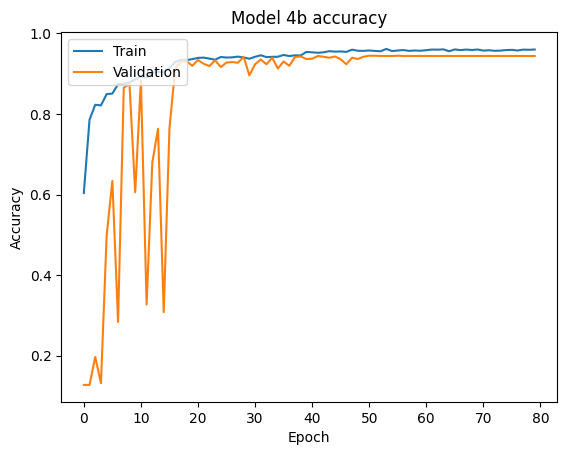

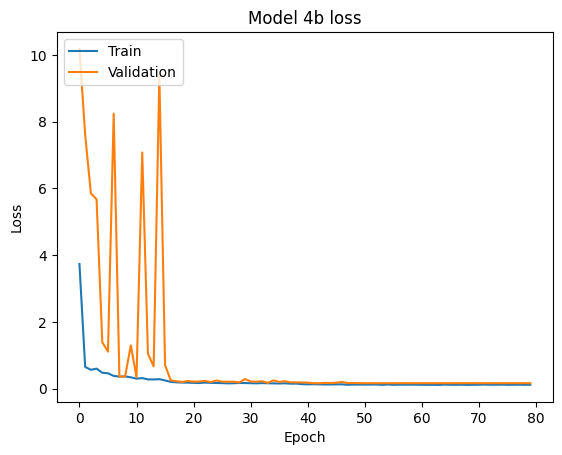

In [79]:
# Evaluate the model on the validation data for this fold

train_loss_cnn_b, train_accuracy_cnn_b = model_cnn_b.evaluate(x_train_cnn, y_train_cnn, verbose=0)
val_loss_cnn_b, val_accuracy_cnn_b = model_cnn_b.evaluate(x_validate_cnn, y_validate_cnn, verbose=0)


# Predict the class labels for the validation data
y_val_pred_cnn_b = model_cnn_b.predict(x_validate_cnn)
y_val_true_cnn_b = np.argmax(y_validate_cnn, axis=1)
y_val_pred_cnn_b = np.argmax(y_val_pred_cnn_b, axis=1)

# Precision scores
precision_cnn_b = precision_score(y_validate_original_cnn, y_val_pred_cnn_b, average='weighted')
f1_cnn_b = f1_score(y_validate_original_cnn, y_val_pred_cnn_b, average='weighted')
recall_cnn_b = recall_score(y_validate_original_cnn, y_val_pred_cnn_b, average='weighted')


# Plot the training and validation accuracy over epochs
plt.plot(history_cnn_b.history['accuracy'])
plt.plot(history_cnn_b.history['val_accuracy'])
plt.title('Model 4b accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_cnn_b.history['loss'])
plt.plot(history_cnn_b.history['val_loss'])
plt.title('Model 4b loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluatation: Metrics, Loss and ROC Graph Model 4c

In [80]:
# Evaluate the model on the validation data
train_loss_cnn_c, train_accuracy_cnn_c = model_cnn_c.evaluate(x_train_cnn, y_train_cnn, verbose=0)
val_loss_cnn_c, val_accuracy_cnn_c = model_cnn_c.evaluate(x_validate_cnn, y_validate_cnn, verbose=0)

# Predict the class labels for the validation data
y_val_pred_cnn_c = model_cnn_c.predict(x_validate_cnn)
y_val_true_cnn_c = np.argmax(y_validate_cnn, axis=1)
y_val_pred_cnn_c = np.argmax(y_val_pred_cnn_c, axis=1)

# Precision scores
precision_cnn_c = precision_score(y_validate_original_cnn, y_val_pred_cnn_c, average='weighted')
f1_cnn_c = f1_score(y_validate_original_cnn, y_val_pred_cnn_c, average='weighted')
recall_cnn_c = recall_score(y_validate_original_cnn, y_val_pred_cnn_c, average='weighted')

63/63 [==============================] - 0s 2ms/step


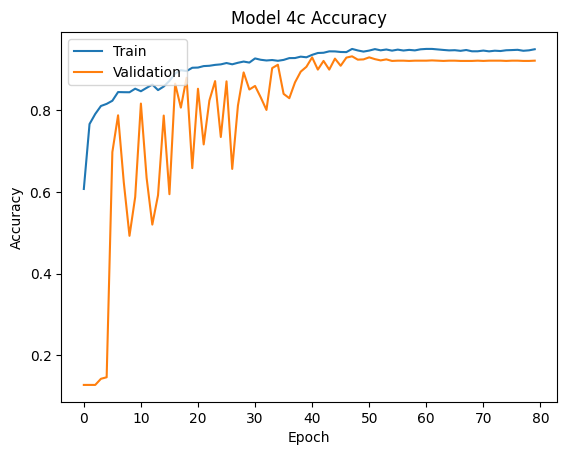

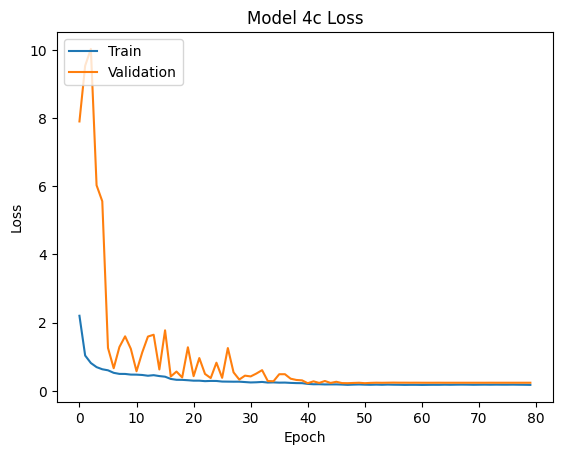

63/63 [==============================] - 0s 3ms/step


<ipython-input-81-63c892e408ba>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


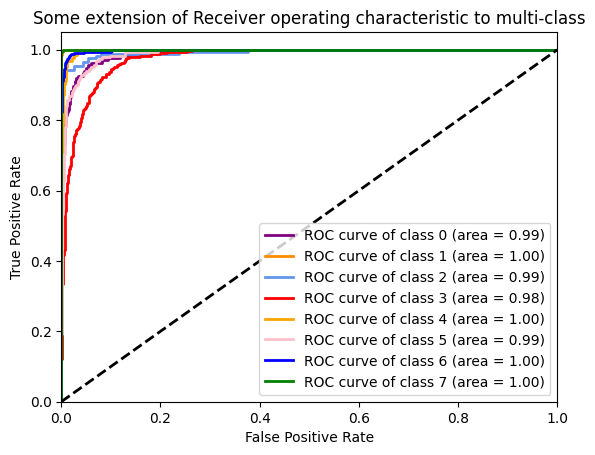

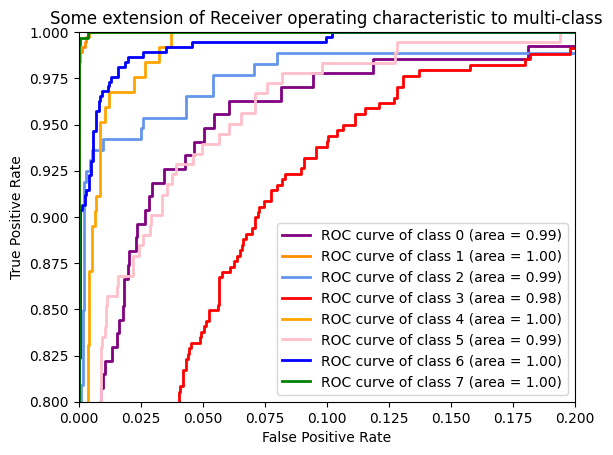

In [81]:
# Plot the training and validation accuracy over epochs
plt.plot(history_cnn_c.history['accuracy'])
plt.plot(history_cnn_c.history['val_accuracy'])
plt.title('Model 4c Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_cnn_c.history['loss'])
plt.plot(history_cnn_c.history['val_loss'])
plt.title('Model 4c Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

y_val_pred = model_cnn_c.predict(x_validate_cnn)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_validate_cnn[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_validate_cnn.ravel(), y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 8

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)

colors = cycle(['purple', 'darkorange', 'cornflowerblue', 'red', 'orange', 'pink', 'blue', 'green'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

colors = cycle(['purple', 'darkorange', 'cornflowerblue', 'red', 'orange', 'pink', 'blue', 'green'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix Model 4a

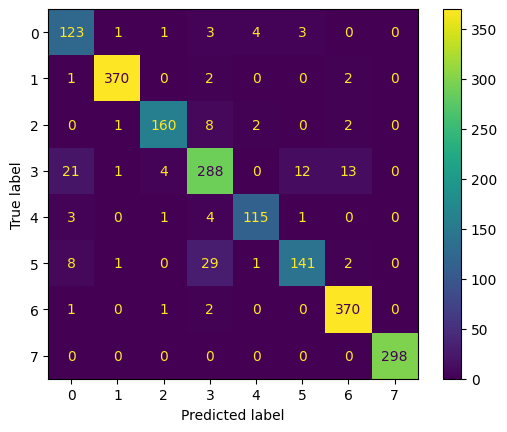

In [82]:
# Calculate the confusion matrix and average accuracy across all folds
conf_mat_cnn = confusion_matrix(y_validate_original_cnn, y_val_pred_cnn)

# Display confusion matrix
cm_display_cnn = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_cnn) 
cm_display_cnn.plot()
plt.show()

#Confusion Matrix Model 4b

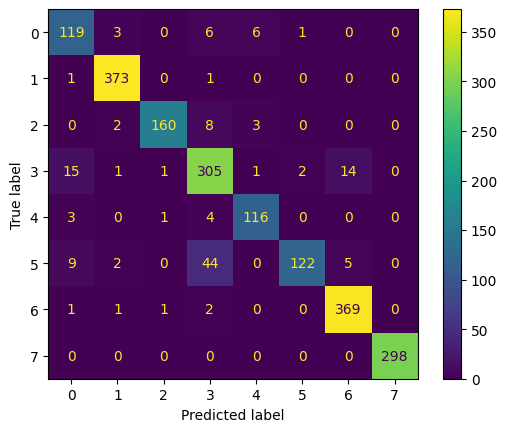

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Calculate the confusion matrix and average accuracy across all folds
conf_mat_cnn_b = confusion_matrix(y_val_true_cnn_b, y_val_pred_cnn_b)

cm_display_cnn_b = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_cnn_b)
    
cm_display_cnn_b.plot()
plt.show()

# average_accuracy_cnn = np.mean(val_acc_scores_cnn)
# print('Average Accuracy:', average_accuracy_cnn)

#Confusion Matrix Model 4c

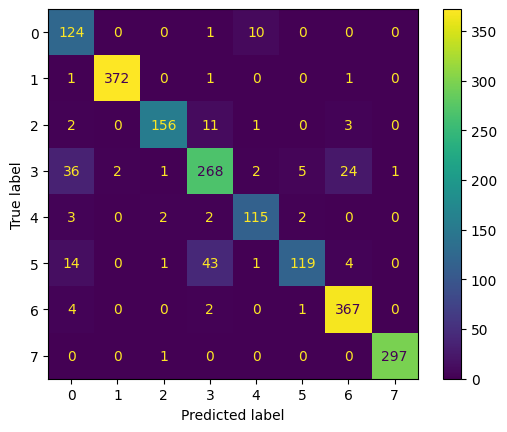

In [84]:
# Calculate the confusion matrix and average accuracy across all folds
conf_mat_cnn_c = confusion_matrix(y_validate_original_cnn, y_val_pred_cnn_c)

# Display confusion matrix
cm_display_cnn_c = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat_cnn_c)
cm_display_cnn_c.plot()
plt.show()

#Summarise Performance Model 4a

In [85]:
# # Summarize the performance
# print('Cross Validate Mean Accuracy: ', cv_mean_cnn)


print('Validation Accuracy: ', val_accuracy_cnn)
print('Training Accuracy: ', train_accuracy_cnn)

# # print('Train Accuracy: %.3f%% (%.3f%%)' % (np.mean(train_acc_scores_cnn)*100, np.std(train_acc_scores_cnn)*100))
# # print('Validation Accuracy: %.3f%% (%.3f%%)' % (np.mean(val_acc_scores_cnn)*100, np.std(val_acc_scores_cnn)*100))
# # print('Train Loss: %.3f (%.3f)' % (np.mean(train_loss_scores_cnn), np.std(train_loss_scores_cnn)))
# # print('Validation Loss: %.3f (%.3f)' % (np.mean(val_loss_scores_cnn), np.std(val_loss_scores_cnn)))

print('Train Loss: ', train_loss_cnn)
print('Validation Loss: ', (val_loss_cnn))

print(classification_report(y_validate_original_cnn, y_val_pred_cnn))


Validation Accuracy:  0.9325000047683716
Training Accuracy:  0.9516249895095825
Train Loss:  0.13475416600704193
Validation Loss:  0.20749631524085999
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       135
           1       0.99      0.99      0.99       375
           2       0.96      0.92      0.94       173
           3       0.86      0.85      0.85       339
           4       0.94      0.93      0.93       124
           5       0.90      0.77      0.83       182
           6       0.95      0.99      0.97       374
           7       1.00      1.00      1.00       298

    accuracy                           0.93      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



#Summarise Performance Model 4b

In [86]:
# # Summarize the performance
# print('Cross Validate Mean Accuracy: ', cv_mean_cnn)


print('Validation Accuracy: ', val_accuracy_cnn_b)
print('Training Accuracy: ', train_accuracy_cnn_b)

# # print('Train Accuracy: %.3f%% (%.3f%%)' % (np.mean(train_acc_scores_cnn)*100, np.std(train_acc_scores_cnn)*100))
# # print('Validation Accuracy: %.3f%% (%.3f%%)' % (np.mean(val_acc_scores_cnn)*100, np.std(val_acc_scores_cnn)*100))
# # print('Train Loss: %.3f (%.3f)' % (np.mean(train_loss_scores_cnn), np.std(train_loss_scores_cnn)))
# # print('Validation Loss: %.3f (%.3f)' % (np.mean(val_loss_scores_cnn), np.std(val_loss_scores_cnn)))

print('Train Loss: ', train_loss_cnn_b)
print('Validation Loss: ', (val_loss_cnn_b))

print(classification_report(y_validate_original_cnn, y_val_pred_cnn_b))


Validation Accuracy:  0.9309999942779541
Training Accuracy:  0.9548749923706055
Train Loss:  0.1373356729745865
Validation Loss:  0.18825560808181763
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       135
           1       0.98      0.99      0.99       375
           2       0.98      0.92      0.95       173
           3       0.82      0.90      0.86       339
           4       0.92      0.94      0.93       124
           5       0.98      0.67      0.79       182
           6       0.95      0.99      0.97       374
           7       1.00      1.00      1.00       298

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000



#Summarise Performance Model 4c

In [87]:
# # Summarize the performance
print('Validation Accuracy: ', val_accuracy_cnn_c)
print('Training Accuracy: ', train_accuracy_cnn_c)
print('Precision Score: ', precision_cnn_c)
print('F1 score: ', f1_cnn_c)
print('Recall score: ', recall_cnn_c)
print('Train Loss: ', train_loss_cnn_c)
print('Validation Loss: ', (val_loss_cnn_c))
print(classification_report(y_validate_original_cnn, y_val_pred_cnn_c))


Validation Accuracy:  0.9089999794960022
Training Accuracy:  0.9286249876022339
Precision Score:  0.9153355643038434
F1 score:  0.9082566915323501
Recall score:  0.909
Train Loss:  0.22126345336437225
Validation Loss:  0.2845107913017273
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       135
           1       0.99      0.99      0.99       375
           2       0.97      0.90      0.93       173
           3       0.82      0.79      0.80       339
           4       0.89      0.93      0.91       124
           5       0.94      0.65      0.77       182
           6       0.92      0.98      0.95       374
           7       1.00      1.00      1.00       298

    accuracy                           0.91      2000
   macro avg       0.90      0.90      0.89      2000
weighted avg       0.92      0.91      0.91      2000



#Predict on Test Data

#Re-train Final Model

#Mount Google Drive

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
!ls "/content/drive/MyDrive"
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/COM2028_2023.zip', 'r')
zip_ref.extractall()
zip_ref.close()

'68321556 3.pdf'			     Football.mp4
'AC 11.09.18.docx'			    'FULHAM ROTA.xlsx'
'Anna Carter A level.gdoc'		    'headshot (1).png'
'Anna Carter A level.pdf'		     headshot.png
'Anna Carter Medical History.docx'	    'Memories Of The Future.gslides'
'Colab Notebooks'			     Nanny.gdoc
 COM2028_2023.zip			    'Robots taking over the world.mp4'
'Contract Update Letter - Anna Carter.pdf'  'Untitled presentation.gslides'


# Load Test Dataset

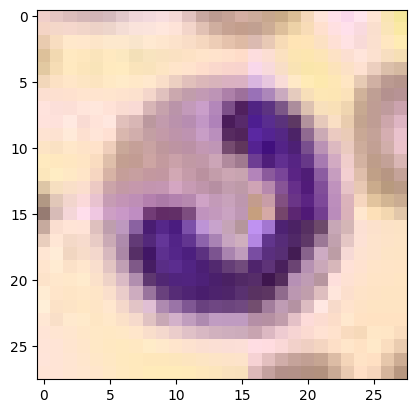

In [108]:
# holds test data 
x_test=[]

for id in range(5000):
  # Convert the id into a valid padded number
  bloodcell = str(id)
  bloodcell = bloodcell.zfill(5)
  # Fetch the filename and add to the array
  t_fetched = plt.imread(f'test/{bloodcell}.jpg')
  x_test.append(t_fetched)

plt.imshow(x_test[2])

#Load Training Data

In [109]:
#holds training data 
data_final=[]

for index in range(10000):
  index_str=str(index)
  reformat=index_str.zfill(6)
  # load the image
  image=plt.imread(f'/content/train/{reformat}.jpg')
  pixels = asarray(image)
  data_final.append(pixels)
data_final=asarray(data_final)
# Hold target labels
target_final=[]

file_train = open('train.txt', 'r')
lines = file_train.readlines()

for line in lines:
  array=line.split(" ")
  number=int(array[1].strip())
  target_final.append(number)
# Convert int array to np array
target_final=asarray(target_final)
# Convert int's to int32 type
target_final=target_final.astype(np.int32)

#One Hot Encoding and Scaling

In [110]:
y_train_original_cnn=target_final
y_train_final = to_categorical(target_final)

x_train_final=data_final/255

#Reshape Test Data

In [111]:
x_test = np.array(x_test)
print('Current shape: ', x_test.shape)
x_test = x_test.reshape(-1, 28,28,3)
print('Reshaped: ', x_test.shape)

x_test=x_test/255

Current shape:  (5000, 28, 28, 3)
Reshaped:  (5000, 28, 28, 3)


#Build Model

In [112]:
model_cnn_final=Sequential([
    # Preprocessing layers
    RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    # Model layers
    Conv2D(32, kernel_size=3, activation="relu", input_shape=(28,28,3)),
    Conv2D(32, kernel_size=3, activation=None, kernel_regularizer=regularizers.L2(0.01)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Conv2D(64, kernel_size=3, activation="relu"),
    Conv2D(64, kernel_size=3, activation=None, kernel_regularizer=regularizers.L2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size=3, activation="relu"),
    Dropout(0.2),
    MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding="valid"),
    Flatten(),
    Dense(8, activation="softmax")
])

#Train Model

In [113]:
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints',
    save_weights_only=True,  # Record only weights (see model.save_weights vs model.save)
    monitor='val_accuracy',  # Evaluate model using accuracy metric on the validation set
    mode='max',        # Determine best model based on 'max' of the 'val_accuracy' score
    save_best_only=True)   # Keep only the best-performing model (i.e. overwrite only when the model has improved)

# Train model
epochs=80
batch_size=64

opt = keras.optimizers.Adam(learning_rate=0.001)
reduce_learning_rate=ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0000001)

model_cnn_final.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn_final=model_cnn_final.fit(x_train_final, y_train_final, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[reduce_learning_rate, checkpoint_callback])



Epoch 1/80
125/125 [==============================] - 6s 20ms/step - loss: 2.2649 - accuracy: 0.5746 - val_loss: 4.6178 - val_accuracy: 0.1245 - lr: 0.0010
Epoch 2/80
125/125 [==============================] - 2s 16ms/step - loss: 0.9530 - accuracy: 0.7940 - val_loss: 3.4043 - val_accuracy: 0.1450 - lr: 0.0010
Epoch 3/80
125/125 [==============================] - 2s 16ms/step - loss: 0.6879 - accuracy: 0.8379 - val_loss: 4.2078 - val_accuracy: 0.1665 - lr: 0.0010
Epoch 4/80
125/125 [==============================] - 2s 16ms/step - loss: 0.5851 - accuracy: 0.8431 - val_loss: 2.7559 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/80
125/125 [==============================] - 2s 18ms/step - loss: 0.5258 - accuracy: 0.8534 - val_loss: 1.5874 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 6/80
125/125 [==============================] - 2s 18ms/step - loss: 0.4817 - accuracy: 0.8608 - val_loss: 0.7335 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 7/80
125/125 [==============================] - 2s 15ms/st

#Make Prediction using CNN Model 4 - CNN

In [114]:
results=model_cnn_final.predict(x_test)

157/157 [==============================] - 0s 3ms/step


In [115]:
results = np.argmax(results, axis=1)

print(results)

[1 3 6 ... 2 0 4]


#Save Final Model

In [116]:
model_cnn_c.save("CNN_Model")

#Reload

In [117]:
reloadModel=keras.models.load_model("CNN_Model")

#Download Results into Text File

In [118]:
# Open a file for writing the results
with open('test.txt', 'w') as f:
    # Loop through each predicted label and write it to the file
    for i in range(len(results)):
        number=str(i)
        number=number.zfill(5)
        filename='test/' + number +'.jpg'
        # Write the filename and predicted label to the file, separated by a space
        f.write(filename + ' ' + str(results[i]) + '\n')